In [ ]:
import os

from matplotlib import pyplot as plt
plt.style.use('bmh')

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook as tqdm

from piaa.utils import pipeline
from piaa.utils import helpers
from piaa.utils import plot
from piaa.utils.postgres import get_cursor

from pocs.utils.images import fits as fits_utils
from astropy.io import fits

tess_cursor = get_cursor(port=5433, db_name='v6', db_user='postgres')

## Specify Target

Here we look up the target HD189733 by the 2MASS ID.

In [ ]:
twomass = '20004370+2242391'

picid = helpers.get_star_info(twomass_id=twomass, cursor=tess_cursor).id  # HD 189733
print(f'PICID: {picid}')

#### Observation sources

We use the previously detected and filtered sources to examine our target. See the [Source-Detection](Source-Detection-And-Filtering.ipynb) for details.

In [ ]:
base_dir = '/var/panoptes/images/fields/PAN012/358d0f/20180822T035809/'
source_filename = os.path.join(base_dir, f'point-sources-filtered.csv')

In [ ]:
sources = pipeline.lookup_sources_for_observation(filename=source_filename)

In [ ]:
target_table = sources.loc[sources.picid == picid]
target_table.head()

#### Basic Aperture Photometry - sextractor

Values are coming from `sextractor`.

In [ ]:
min_bin = 20
plt.figure(figsize=(12, 9))
target_table.mag_auto.plot(ls='', marker='o', yerr=target_table.magerr_auto, alpha=0.4, label='Raw Mag')
target_table.resample(f'{min_bin}T').mean().mag_auto.plot(ls='', marker='o', ms=8, yerr=target_table.magerr_auto.mean(), label=f'{min_bin}-Min Mean Raw Mag')
plt.title(f'Raw Magnitude RMS {target_table.magerr_auto.mean():.02%} SNR {target_table.snr.mean():.0f}')
plt.ylabel('Instrumental Magnitude')
plt.gca().invert_yaxis()
plt.legend()
plt.show()

#### Differential photometry - sextractor

Get some of the bright stars in the sequence and use them to normalize the target.

In [ ]:
bright_stars = sources.groupby('picid').snr.mean().sort_values(ascending=False).index.values[1:5]

bright_table = sources.loc[np.isin(sources.picid, bright_stars)]

In [ ]:
corrected_flux = (target_table.flux_auto / bright_table.groupby('obs_time').flux_auto.sum())

In [ ]:
plt.figure(figsize=(12, 9))
(corrected_flux / corrected_flux.mean()).plot(ls='', marker='o')
(corrected_flux / corrected_flux.mean()).resample('15T').mean().plot(ls='', marker='o', ms=8)
plt.ylim([.5, 1.5])
plt.title('Simple Differential Photometry')

**Todo** Show the color channel photometry

In [ ]:
camera_bias = 2048

In [10]:
stamp_size = 4

color_sums = list()
for date_obs, row in tqdm(target_table.iterrows(), total=len(target_table)):
    # Get the target stamp for this frame
    data = fits.getdata(os.path.join(base_dir, row.file)) #- camera_bias
    target_slice = helpers.get_stamp_slice(row.x, row.y, stamp_size=(stamp_size, stamp_size), ignore_superpixel=True)
    stamp = data[target_slice] - row.background

    row_sums = [stamp.sum()]
    row_sums.extend(helpers.get_rgb_data(stamp).reshape(3, -1).sum(1))
    color_sums.append(row_sums)

color_sums = pd.DataFrame(color_sums, columns=['all', 'r', 'g', 'b'], index=target_table.index)

In [11]:
norm_colors = (color_sums / color_sums.mean())

In [12]:
norm_combined = (target_table.flux_auto / target_table.flux_auto.mean())

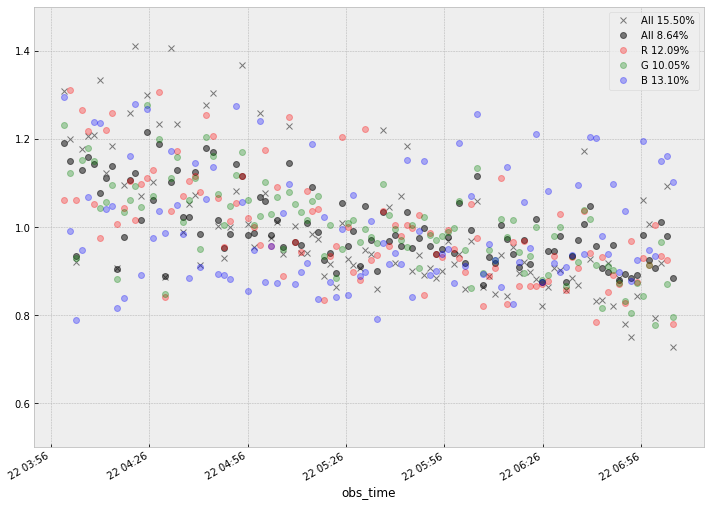

In [15]:
plt.figure(figsize=(12, 9))

norm_combined.plot(ls='', marker='x', color='k', alpha=0.5, label=f'All {norm_combined.std():.02%}')

norm_colors['all'].plot(ls='', marker='o', color='k', alpha=0.5, label='All {:.02%}'.format(norm_colors['all'].std()))
norm_colors.r.plot(ls='', marker='o', color='r', alpha=0.3, label=f'R {norm_colors.r.std():.02%}')
norm_colors.g.plot(ls='', marker='o', color='g', alpha=0.3, label=f'G {norm_colors.g.std():.02%}')
norm_colors.b.plot(ls='', marker='o', color='b', alpha=0.3, label=f'B {norm_colors.b.std():.02%}')

plt.ylim(0.5, 1.5)
plt.legend()

## Find similar stars

Because a simple differential photometry doesn't work well we need to find a suitable set of reference stars that undergo the same changes (e.g. airmass, cloud cover, etc) as our target star.

Ultimately we are concerned about how the flux of our target changes with respect to a suitable set of reference stars and therefore we need to be careful **not** to use flux as a selection parameter for determining the "best" reference stars. That is, we **do not** want to choose reference stars that undergo a reduction of flux in the middle of the observation as this will hide the transit signal in our target.

We can marginalize across the flux by normalizing each stamp to the total flux in the stamp (see [Normalize](Algorithm.ipynb#normalize) in algorithm description). By doing so we are effectively looking at the shape of the star as it appears on the RGB pixel pattern. This morphology will change slightly from frame to frame so we want to look for reference stars that change similarly to our target star with respect to this morphology.

By taking the summed squared difference (SSD) between each pixel of the normalized target and reference star we can get a single metric that defines how well the reference star matches the target. Because the SSD is looking at the difference between the target and a reference, a lower metric value for the refernce indicates a better match with the target. The target stamp compared with itself would yield a value of zero.

We perform the SSD for each frame in the observation and take the sum of all the SSDs for each source as the final metric score to compare against our target. Again, lower scores mean that the reference is more "similar" in a morphological sense: it's shape on the RGB pattern changes similar to that of the target. See [Find Reference Stars](Algorithm.ipynb#find_reference) for details and mathematical description.